In [34]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [35]:
%cd /content/gdrive/MyDrive/comp0197-cw2

/content/gdrive/MyDrive/comp0197-cw2


In [1]:
# autoreload modules if they are edited while using the notebook
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import model_UNet
from preprocessing_1_dataloader import get_data
from data_augmentation import augmentation, colorjiter, invert
import matplotlib.pyplot as plt

In [5]:
#### Hyper-Param ####

# device to use
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #Enable GPU support
# device = 'cpu'
print(f'Using device: {device}')

# data parms
supervised_percent = 0.5    # what percent of training is to be labelled
img_resize = 64             # resize all images to this size 
is_only_labelled = True     # Training only on supervised data or not

# model params
depth = 3       # depth of unet

# Training params
batch_size = 16
epochs = 15
ramp_up = 10
consistency = 56
alpha = 0.8
global_step = 0

Using device: cpu


In [4]:
#### Initialisation ####
#create 2 network
modelS = model_UNet.UNet(in_channels=3, num_classes=2, depth=depth)
modelS = modelS.to(device)
modelT = model_UNet.UNet(in_channels=3, num_classes=2, depth=depth)
modelT = modelT.to(device)
#create the losses
sup_crit = nn.CrossEntropyLoss().to(device)
#optimizer
optimizer = Adam(modelS.parameters())

##data loader
mixed_train_loader, val_loader, test_loader = get_data(supervised_percent,1-supervised_percent,0.2,0.1, batch_size=batch_size, img_resize=img_resize, is_mixed_loader=is_only_labelled)

/home/fred/repositories/comp0197-cw2/model_UNet.py:211: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight)
/home/fred/repositories/comp0197-cw2/model_UNet.py:212: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)


Using downloaded and verified file: ./data/images.tar.gz
Using downloaded and verified file: ./data/annotations.tar.gz
all images are =  7393


In [5]:
#Weigth coef for the Unsupervised
def wt(rampup_length, current, alpha):
    if rampup_length == 0:
                return 1.0
    else:
        current = np.clip(current, 0.0, rampup_length)
        phase = 1.0 - current / rampup_length
        return float(alpha * np.exp(-5.0 * phase * phase))


#update the Teacher weigth
def update_ema_variables(model, ema_model, alpha, global_step): 
    # Use the true average until the exponential average is more correct
    alpha = min(1 - 1 / (global_step + 1), alpha)
    for ema_param, param in zip(ema_model.parameters(), model.parameters()):
        ema_param.data.mul_(alpha).add_(1 - alpha, param.data)

In [6]:
def softmax_mse_loss(inputs, targets):

    assert inputs.requires_grad is True and targets.requires_grad is False
    assert inputs.size() == targets.size()  # (batch_size * num_classes * H * W)
    
    inputs = F.softmax(inputs, dim=1)
    targets = F.softmax(targets, dim=1)
    
    return F.mse_loss(inputs, targets, reduction='mean')  # take the mean over the batch_size

In [7]:
def evaluate_model(loader, model, device):

    pixel_correct, pixel_count = 0, 0

    with torch.no_grad():
        
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            z = model(inputs)

            probs = F.softmax(z, dim=1)
            preds = torch.argmax(probs, dim=1)

            labels = labels.squeeze().to(device)

            pixel_correct += (preds == labels).sum()

            pixel_count += labels.numel()

    accuracy = pixel_correct / pixel_count
    return  accuracy

In [8]:
# check minibatch dimensions
data = next(iter(mixed_train_loader))
imgs, labels = data
imgs, labels = imgs.to(device), labels.to(device)

print(imgs.shape)

torch.Size([16, 3, 64, 64])


In [9]:
# Train
eval_freq = 1
for epoch in range(epochs):
        modelS.train()
        running_loss = 0

        for step, data in enumerate(mixed_train_loader):
            imgs, labs = data
            imgs = imgs.to(device)
            labs = labs.squeeze().type(torch.LongTensor).to(device)

            optimizer.zero_grad()

            # Forward pass for student and teacher
            z = modelS(imgs) 
            with torch.no_grad():
              z_bar = modelT(imgs)

            # Find img with label
            sup_idx = torch.tensor([(elem != -1).item() for elem in labs[:, 0, 0]]).to(device) #If batchsize is the first dim

            assert len(sup_idx) != 0

            # Calculate losses
            Ls = sup_crit(z[sup_idx], labs[sup_idx])
            Lu = softmax_mse_loss(z, z_bar).to(device)

            loss = Ls  # + wt(ramp_up, epoch, consistency) * Lu
            loss.backward()
            optimizer.step()    
            global_step += 1
            update_ema_variables(modelS, modelT, alpha, global_step)
            running_loss += loss.item()

        if epoch == 0:
                print('\n{:<10s}{:<10s}'.format('', 'Running loss')) 
        
        print(f'Epoch: {epoch + 1:4d} - Loss: {running_loss:6.2f}')

        if (epoch % eval_freq == 0):
          modelS.eval()
          accuracy = evaluate_model(val_loader, modelS, device).item()
          modelS.train()
          print(f'accuracy: {accuracy:2.0%}')

: 

: 

### View some of the predictions

In [63]:
data = next(iter(val_loader))
imgs, labels = data
imgs, labels = imgs.to(device), labels.to(device)
labels = torch.squeeze(labels)

preds = modelS(imgs)
_, preds_class = torch.max(preds, dim=1)

labels = labels.to('cpu')
imgs = imgs.to('cpu')
preds_class = preds_class.to('cpu')

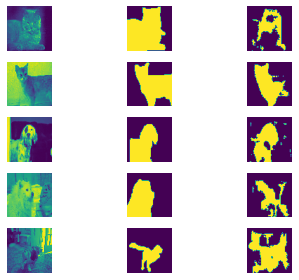

In [71]:
max_id = 5

fig, axs = plt.subplots(nrows=max_id, ncols=3)

for row in range(max_id):
  axs[row, 0].imshow(imgs[row,0])
  axs[row, 1].imshow(labels[row])
  axs[row, 2].imshow(preds_class[row])
  axs[row,0].axis('off')
  axs[row,1].axis('off')
  axs[row,2].axis('off')

fig.tight_layout()
fig.show()